# install library

In [1]:
import os

if os.environ.get("KAGGLE_KERNEL_RUN_TYPE") is None:
    ON_KAGGLE = False
else:
    ON_KAGGLE = True
if not ON_KAGGLE:
    import shutil
    from requests import get

    from google.colab import drive, files
    # mount Google Drive
    drive.mount("/content/drive")
else:
    for dirname, _, filenames in os.walk('/kaggle/input'):
        for filename in filenames:
            print(os.path.join(dirname, filename))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
if not ON_KAGGLE: 
    !pip uninstall -y kaggle
    !pip install kaggle
    !mkdir /root/.kaggle
    !cp /content/drive/MyDrive/kaggla-za/kaggle.json /root/.kaggle
    !kaggle datasets download -d  kozodoi/timm-pytorch-image-models
    !mkdir -p ../input/timm-pytorch-image-models
    !unzip -n -qq timm-pytorch-image-models.zip -d ../input/timm-pytorch-image-models

    #一回のみ
    # !kaggle datasets download -d kalfirst/animal-imbalance-classification-round2
    # !mkdir -p ../content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/data/animal-imbalance-classification-round2
    # !unzip -n -qq animal-imbalance-classification-round2.zip -d ../content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/data/animal-imbalance-classification-round2

    !kaggle datasets download -d kalfirst/animal-imbalance-classification-round2
    !mkdir -p ../input/animal-imbalance-classification-round2
    !unzip -n -qq animal-imbalance-classification-round2.zip -d ../input/animal-imbalance-classification-round2


Found existing installation: kaggle 1.5.12
Uninstalling kaggle-1.5.12:
  Successfully uninstalled kaggle-1.5.12
  Using cached kaggle-1.5.12-py3-none-any.whl
mkdir: cannot create directory ‘/root/.kaggle’: File exists
timm-pytorch-image-models.zip: Skipping, found more recently modified local copy (use --force to force download)
animal-imbalance-classification-round2.zip: Skipping, found more recently modified local copy (use --force to force download)


In [3]:
import sys
sys.path.append("../input/timm-pytorch-image-models/pytorch-image-models-master")

if not ON_KAGGLE:
    !pip install albumentations==0.4.6
import albumentations as A
from albumentations.pytorch import ToTensorV2

import gc
import math
import os
import pickle
import random
import re
import time
import warnings
from contextlib import contextmanager

from pathlib import Path
from PIL import Image

#import albumentations as A
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
import torch
import torch.nn as nn
import torch.nn.functional as F


#from albumentations.pytorch import ToTensorV2
from scipy.special import softmax
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from torch.optim import SGD, Adam, AdamW, RAdam
from torch.optim.lr_scheduler import CosineAnnealingLR, CosineAnnealingWarmRestarts, ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset
from tqdm.auto import tqdm

import timm
warnings.filterwarnings('ignore')

# Config


In [4]:
class Config:
    Version = "exp36" # model save時のversion
    #MODEL_NAME = "resnet34" # モデル名
    #MODEL_NAME = "efficientnet_b0" # モデル名
    #MODEL_NAME = "efficientnet_b1" # モデル名
    #MODEL_NAME = "efficientnet_b2" # モデル名
    #MODEL_NAME = "efficientnet_b3" # モデル名
    #MODEL_NAME = "efficientnet_b4" # モデル名
    #MODEL_NAME = "efficientnet_b5" # モデル名
    #MODEL_NAME = "efficientnet_b6" # モデル名
    #MODEL_NAME = "efficientnet_b7" # モデル名
    #MODEL_NAME = "tf_efficientnet_b0_ns" # モデル名
    #MODEL_NAME = "tf_efficientnet_b1_ns" # モデル名
    #MODEL_NAME = "resnet50" # モデル名
    # MODEL_NAME = "swin_large_patch4_window7_224"
    # MODEL_NAME = "swin_base_patch4_window7_224"
    #MODEL_NAME = "swin_small_patch4_window7_224"
    # MODEL_NAME = "swin_large_patch4_window12_384"
    # MODEL_NAME = "swin_base_patch4_window12_384"
    # MODEL_NAME = "vit_base_patch16_224"
    MODEL_NAME = 'nfnet_f1'



    if ON_KAGGLE:
        # if MODEL_NAME == 'resnet34':
        #     model_name = '../input/pt-longformer-base' # https://www.kaggle.com/kishalmandal/pt-longformer-base
        # elif MODEL_NAME == 'roberta-base':
        #     model_name = '../input/roberta-base' #https://www.kaggle.com/abhishek/roberta-base
        # elif modeMODEL_NAMEl_savename == 'roberta-large':
        #     model_name = '../input/robertalarge' # https://www.kaggle.com/marshal02/robertalarge
        # elif MODEL_NAME == 'longformer-large':
        #     model_name = '../input/longformerlarge4096' # https://www.kaggle.com/hengzheng/longformerlarge4096 
        #base_dir = '/content/drive/MyDrive/petfinder'
        #data_dir = '../input/digit-recognizer/' # = DATA_PATH
        data_dir = '../input/animal-imbalance-classification-round2' # = DATA_PATH
        pre_data_dir = './preprocessed/'
        model_dir = '.'
        output_dir = '.'   
    else:
        # customize for my own Google Colab Environment
        # if model_savename == 'longformer':
        #     model_name = 'allenai/longformer-base-4096'
        # elif model_savename == 'roberta-base':
        #     model_name = 'roberta-base'
        base_dir = '/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance'
        data_dir = '../input/animal-imbalance-classification-round2' #os.path.join(base_dir, '../input/animal-imbalance-classification-round2')
        #pre_data_dir = os.path.join(base_dir, 'data/preprocessed')
        model_dir = os.path.join(base_dir, f'model/{Version}')
        output_dir = os.path.join(base_dir, f'output/{Version}')    

    is_debug = False
    if MODEL_NAME == 'resnet34':
        size = 224 # リサイズした後の画像のサイズ
        model_lr = 1e-5
    elif MODEL_NAME == 'roberta-base':
        size = 224 # リサイズした後の画像のサイズ
        model_lr = 1e-5
    elif MODEL_NAME == 'resnet50':
        size = 64 # リサイズした後の画像のサイズ
        model_lr = 1e-5
    elif MODEL_NAME == 'swin_large_patch4_window7_224':
        size = 224 # リサイズした後の画像のサイズ
        model_lr = 1e-5
    elif MODEL_NAME == 'swin_base_patch4_window7_224':
        size = 224 # リサイズした後の画像のサイズ
        model_lr = 1e-5
    elif MODEL_NAME == 'swin_small_patch4_window7_224':
        size = 224 # リサイズした後の画像のサイズ
        model_lr = 1e-5
    elif MODEL_NAME == 'swin_large_patch4_window12_384':
        size = 384 # リサイズした後の画像のサイズ
        model_lr = 1e-5
    elif MODEL_NAME == 'swin_base_patch4_window12_384':
        size = 384 # リサイズした後の画像のサイズ
        model_lr = 1e-5
    elif MODEL_NAME == 'efficientnet_b0':
        size = 224 # リサイズした後の画像のサイズ
        model_lr = 1e-5
    elif MODEL_NAME == 'efficientnet_b1':
        size = 224 # リサイズした後の画像のサイズ
        model_lr = 1e-5
    elif MODEL_NAME == 'efficientnet_b2':
        size = 224 # リサイズした後の画像のサイズ
        model_lr = 1e-5
    elif MODEL_NAME == 'efficientnet_b3':
        size = 224 # リサイズした後の画像のサイズ
        model_lr = 1e-5
    elif MODEL_NAME == 'efficientnet_b4':
        size = 224 # リサイズした後の画像のサイズ
        model_lr = 1e-5
    elif MODEL_NAME == 'efficientnet_b5':
        size = 224 # リサイズした後の画像のサイズ
        model_lr = 1e-5
    elif MODEL_NAME == 'efficientnet_b6':
        size = 224 # リサイズした後の画像のサイズ
        model_lr = 1e-5
    elif MODEL_NAME == 'efficientnet_b7':
        size = 224 # リサイズした後の画像のサイズ
        model_lr = 1e-5
    elif MODEL_NAME == 'tf_efficientnet_b0_ns':
        size = 224 # リサイズした後の画像のサイズ
        model_lr = 1e-5
    elif MODEL_NAME == 'tf_efficientnet_b1_ns':
        size = 224 # リサイズした後の画像のサイズ
        model_lr = 1e-5
    elif MODEL_NAME == 'vit_base_patch16_224':
        size = 224 # リサイズした後の画像のサイズ
        model_lr = 1e-5
    elif MODEL_NAME == 'nfnet_f1':
        size = 224 # リサイズした後の画像のサイズ
        model_lr = 1e-5
    seed = 42 # seed値
    fold = 0
    num_workers = 4  #並列実行する数 was 0
    batch_size =  64 #バッチサイズ was 64 >100
    epochs = 25 #エポック数 10?
    #size = 224 # リサイズした後の画像のサイズ
    #model_lr = 1e-5 # 学習率
    T_max = 10 # 最大イテレーション数 was 10
    min_lr = 1e-3 # 学習率の最小値 was 1e-5
    weight_decay = 1e-6 # 学習減衰値
    max_grad_norm = 1000 # 勾配の最大ノルム
    print_freq = 1000 # 学習結果を表示する頻度
    probability = 0.6
    class_num = 10 
    norms = (0.5, 0.5)
    device = "cuda" if torch.cuda.is_available() else "cpu" # CPU of GPU


In [5]:
if not ON_KAGGLE:
    if not os.path.exists(Config.model_dir):
        !mkdir $Config.model_dir
    if not os.path.exists(Config.output_dir):
        !mkdir $Config.output_dir

In [6]:
# from google.colab import drive
# drive.mount('/content/drive')

# Utils

In [7]:
def init_logger(log_file='train.log'):
    """Output Log."""
    from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger


def seed_torch(seed=Config.seed): # was seed=0
    """Fixed seed value."""
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False # added trueにすると再現性がなくなる


LOGGER = init_logger()
seed_torch(seed=Config.seed)

In [8]:
def asMinutes(s):
    """Convert Seconds to Minutes."""
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    """Accessing and Converting Time Data."""
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))

class AverageMeter(object):
    """Computes and stores the average and current value."""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

# Dataset

In [9]:
class TrainDataset(Dataset):
    """Dataset used for training."""
    def __init__(self, df, transform=None):
        self.df = df
        self.image_paths = df['image_id'].values
        self.labels = df['label'].values
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        #修正部分
        path = self.image_paths[idx]
        image = np.array(Image.open(path))
        # image = self.df.loc[idx, "pixel0": "pixel783"].values.astype(np.uint8).reshape(28, 28) # csv to image
        # image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB) # GRAY to RGB

        if self.transform:
            augmented = self.transform(image=image) # augmentation
            image = augmented['image']

        label = self.labels[idx] # 正解ラベル
        return image, label

In [10]:
class TestDataset(Dataset):
    """Dataset used for inference."""
    def __init__(self, df, transform=None):
        self.df = df
        self.image_paths = df['image_id'].values
        self.labels = df['label'].values
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        #修正部分
        path = self.image_paths[idx]
        image = np.array(Image.open(path))
        # image = self.df.loc[idx, "pixel0": "pixel783"].values.astype(np.uint8).reshape(28, 28)
        # image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']

        return image

# Data Augmentation

In [11]:
def get_transforms(*, data, size, norms):

    if data == 'train':
        return A.Compose([
            A.Resize(Config.size, Config.size), # リサイズ
            A.Rotate(limit=10, border_mode=cv2.BORDER_REPLICATE, p=0.5),
            A.Cutout(num_holes=8, max_h_size=2, max_w_size=2, fill_value=0, p=0.5),
            A.Cutout(num_holes=8, max_h_size=1, max_w_size=1, fill_value=1, p=0.5),
            # A.VerticalFlip(p=0.5),
            # A.HorizontalFlip(p=0.5),
            A.Normalize(mean=[norms[0], norms[0], norms[0]], std=[norms[1], norms[1], norms[1]], max_pixel_value=255.0, p=1.0), # 正規化
            ToTensorV2(), # Tensor型に変換
        ])

    elif data == 'valid':
        return A.Compose([
            A.Resize(Config.size, Config.size),
            A.Normalize(mean=[norms[0], norms[0], norms[0]], std=[norms[1], norms[1], norms[1]], max_pixel_value=255.0, p=1.0),
            ToTensorV2(),
        ])

# Model

In [12]:
# use timm model no pretrained
class BaseModel(nn.Module):
    def __init__(
        self, model_name=Config.MODEL_NAME, n_class=10, pretrained=False
    ):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained) # model load(pretrained=False: 事前学習なし)
        n_features = self.model.num_features#fc.in_features
        self.model.classifier = nn.Linear(n_features, n_class) # 出力層の次元をクラス数に変更

    def forward(self, x):
        output = self.model(x)
        return output

# train & valid function

In [13]:
def train_fn(train_loader, model, criterion, optimizer, epoch, scheduler):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()

    model.train() # 学習モード
    start = end = time.time()
    global_step = 0

    for step, (images, labels) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(Config.device) # 画像をcpuからgpuヘ
        labels = labels.to(Config.device) # 正解ラベルをcpuからgpuヘ
        batch_size = labels.size(0) 
        y_preds = model(images) # 予測ラベル
        loss = criterion(y_preds, labels) # lossの計算

        losses.update(loss.item(), batch_size) 
        loss.backward() # パラメータの勾配を計算
        
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), Config.max_grad_norm)
        optimizer.step() # モデル更新
        optimizer.zero_grad() # 勾配の初期化
        global_step += 1
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % Config.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(
                   epoch+1, step, len(train_loader), batch_time=batch_time,
                   data_time=data_time, loss=losses,
                   remain=timeSince(start, float(step+1)/len(train_loader)),
                   grad_norm=grad_norm,
                   ))

        del y_preds, images, labels, batch_size
    del batch_time, data_time, model
    gc.collect()
    torch.cuda.empty_cache()
    
    return losses.avg

In [14]:
def valid_fn(valid_loader, model, criterion):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()

    # switch to evaluation mode
    model.eval()
    preds = []
    start = end = time.time()
    for step, (images, labels) in enumerate(valid_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(Config.device)
        labels = labels.to(Config.device)
        batch_size = labels.size(0)
        with torch.no_grad():
        #with torch.inference_mode(): Pytorch: ^1.9
            y_preds = model(images)
            loss = criterion(y_preds, labels)
            losses.update(loss.item(), batch_size)
            
            preds.append(y_preds.softmax(1).to("cpu").numpy().argmax(1))
            del loss
            batch_time.update(time.time() - end)
            end = time.time()
            if step % Config.print_freq == 0 or step == (len(valid_loader)-1):
                print('EVAL: [{0}/{1}] '
                    'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                    'Elapsed {remain:s} '
                    'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                    .format(
                    step, len(valid_loader), batch_time=batch_time,
                    data_time=data_time, loss=losses,
                    remain=timeSince(start, float(step+1)/len(valid_loader)),
                    ))
        del y_preds, images, labels, batch_size
    del batch_time, data_time, model
    gc.collect()
    torch.cuda.empty_cache()

    preds = np.concatenate(preds)

    return losses.avg, preds

# Dataの確認

In [15]:
#data_dir = "../input/digit-recognizer" # ディレクトリパス = data_dir
if ON_KAGGLE:
    train = pd.read_csv(Config.data_dir + "/train.csv") # csvの読み込み
    train['image_id'] = Config.data_dir + '/train_images/' + train['image_id']
else:
    train = pd.read_csv(f'{Config.data_dir}/train.csv')
    train['image_id'] = Config.data_dir + '/train_images/' + train['image_id']

train.head()

image_id  label
0  ../input/animal-imbalance-classification-round...      0
1  ../input/animal-imbalance-classification-round...      0
2  ../input/animal-imbalance-classification-round...      0
3  ../input/animal-imbalance-classification-round...      0
4  ../input/animal-imbalance-classification-round...      0

In [16]:
#train['image_id'][0]

In [17]:
import plotly.express as px

target = train.label.value_counts()
#class_num = len(target)

fig = px.pie(target,
             values='label',
             names=target.index,
             hole=.4, 
             width=500, height=500)
fig.update_traces(textinfo='value+label', pull=0.01)
fig.show()

In [18]:
fig = px.bar(target.sort_index().index, target.sort_index(), width=1000, height=400)
fig.show()

# 前処理

### ホールドアウト

In [19]:
f0, f1 = train_test_split(train, test_size=0.2) # 学習用と評価用に分ける
train["folds"] = -1
train.loc[f0.index, "folds"] = 1
train.loc[f1.index, "folds"] = 0
train

image_id  label  folds
0      ../input/animal-imbalance-classification-round...      0      1
1      ../input/animal-imbalance-classification-round...      0      1
2      ../input/animal-imbalance-classification-round...      0      1
3      ../input/animal-imbalance-classification-round...      0      1
4      ../input/animal-imbalance-classification-round...      0      0
...                                                  ...    ...    ...
36495  ../input/animal-imbalance-classification-round...      9      1
36496  ../input/animal-imbalance-classification-round...      9      1
36497  ../input/animal-imbalance-classification-round...      9      1
36498  ../input/animal-imbalance-classification-round...      9      1
36499  ../input/animal-imbalance-classification-round...      9      0

[36500 rows x 3 columns]

#### 平均と標準偏差を計算

In [20]:
#修正部分
# images = train.loc[:, "pixel0": "pixel783"].values.astype(np.uint8).reshape(-1, 28, 28)
# norms = (np.mean(images[train.folds!=0] / 255), np.std(images[train.folds!=0] / 255)) # 平均と標準偏差を計算
# print("平均と標準偏差: ", norms)

#### 画像サイズの確認と数例を表示

In [21]:
# norms = (0.5, 0.5)
# train_dataset = TrainDataset(train,transform=get_transforms(data='train', size=Config.size, norms=Config.norms)) # 学習用のdatasetを作成
# train_loader = DataLoader(train_dataset, batch_size=Config.batch_size, shuffle=True, num_workers=Config.num_workers, pin_memory=True, drop_last=True)# 学習用のdatasetsのbatchを作成
# image_iter = iter(train_loader)
# images, labels = image_iter.next()

In [22]:
# print("height: ", images.shape[1])
# print("weight: ", images.shape[2])

# for n in range(3):
#     fig, axes = plt.subplots(1, 10, figsize=(20, 30))
#     [axes[i].imshow(images[idx]) for i, idx in enumerate(range(n*10, (n+1)*10))]

#     plt.show()

# 学習の際必要になる知識

## 評価指標(Accuracy), Confusion matrix
#### 詳細については、来週説明

## ハイパラメータの用語簡易説明など

> #### * 学習率 : 学習一回当たりの更新量のようなものです。 今回のデフォルトは1e-5です。
> #### * スケジューラー : epoch数に応じて、学習率を変化させるものです。 今回のデフォルトはCosineAnnealingLRです。
> #### * 損失関数: 正解ラベルと予測ラベルの誤差の大きさを計算する関数。 
> #### * 最適化関数: 効率よく損失を減らすための関数。 
> #### * timm : 画像のコンペでpytorchを使う場合にほぼ確実に使用するライブラリですので、見ておきましょう。[github](https://github.com/rwightman/pytorch-image-models)

# 軽めのモデル作成

### モデルの読み込み

In [23]:
model = BaseModel(Config.MODEL_NAME, Config.class_num)
model

BaseModel(
  (model): NormFreeNet(
    (stem): Sequential(
      (conv1): ScaledStdConv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act2): GELU()
      (conv2): ScaledStdConv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (act3): GELU()
      (conv3): ScaledStdConv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (act4): GELU()
      (conv4): ScaledStdConv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (stages): Sequential(
      (0): Sequential(
        (0): NormFreeBlock(
          (downsample): DownsampleAvg(
            (pool): Identity()
            (conv): ScaledStdConv2d(128, 256, kernel_size=(1, 1), stride=(1, 1))
          )
          (act1): GELU()
          (conv1): ScaledStdConv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))
          (act2): GELU()
          (conv2): ScaledStdConv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (act2b): GELU()
          (conv2b): 

### 最適化関数

In [24]:
# Adam は勾配を移動平均と学習率の調整からなります (MomentumとRMSProp)
#optimizer = Adam(model.parameters(), lr=Config.model_lr, weight_decay=Config.weight_decay, amsgrad=False)
#optimizer = AdamW(model.parameters(), lr=Config.model_lr, weight_decay=Config.weight_decay, amsgrad=False)
optimizer = RAdam(model.parameters(), lr=Config.model_lr, weight_decay=Config.weight_decay)


### スケジューラ

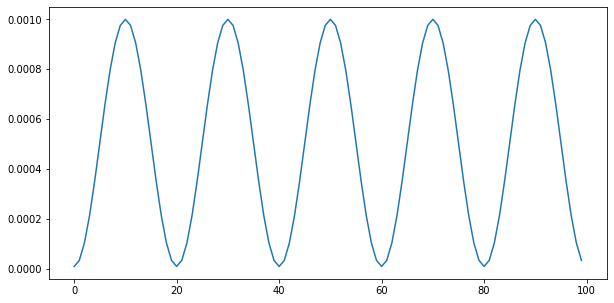

In [25]:
scheduler = CosineAnnealingLR(optimizer, T_max=Config.T_max, eta_min=0.001)

log_s = []
for epoch in range(0, 100):
    log_s.append(scheduler.get_last_lr()[0])
    scheduler.step()

plt.figure(figsize=(10, 5))
plt.plot(np.arange(100), log_s)
plt.show()

# 学習

In [26]:
def train_loop(train, fold, class_num=None, norms=(0.5, 0.5)):
    
    train_index = train[train['folds'] != fold].index # 学習用のindex
    valid_index = train[train['folds'] == fold].index # 評価用のindex

    train_dataset = TrainDataset(train.loc[train_index].reset_index(drop=True), 
                                 transform=get_transforms(data='train', size=Config.size, norms=norms)) # 学習用のdatasetを作成
    valid_dataset = TrainDataset(train.loc[valid_index].reset_index(drop=True), 
                                 transform=get_transforms(data='valid', size=Config.size, norms=norms)) # 評価用のdatasetを作成

    train_loader = DataLoader(train_dataset, batch_size=Config.batch_size, shuffle=True, 
                              num_workers=Config.num_workers, pin_memory=True, drop_last=True)# 学習用のdatasetsのbatchを作成
    valid_loader = DataLoader(valid_dataset, batch_size=Config.batch_size, shuffle=False, 
                              num_workers=Config.num_workers, pin_memory=True, drop_last=False) # 評価用のdatasetsのbatchを作成
    
    
    model = BaseModel(Config.MODEL_NAME, class_num).to(Config.device)

    #optimizer = Adam(model.parameters(), lr=Config.model_lr, weight_decay=Config.weight_decay, amsgrad=False)
    #optimizer = AdamW(model.parameters(), lr=Config.model_lr, weight_decay=Config.weight_decay, amsgrad=False)
    optimizer = RAdam(model.parameters(), lr=Config.model_lr, weight_decay=Config.weight_decay)

    scheduler = CosineAnnealingLR(optimizer, T_max=Config.T_max, eta_min=Config.min_lr, last_epoch=-1)

    criterion = nn.CrossEntropyLoss() # loss function

    best_score = 0.
    best_loss = np.inf
    
    for epoch in range(Config.epochs):
        start_time = time.time()
        avg_loss = train_fn(train_loader, model, criterion, optimizer, epoch, scheduler) # 学習
        avg_val_loss, predict = valid_fn(valid_loader, model, criterion) # 評価用の推論
        valid_labels = train.loc[valid_index, "label"].values # 予測ラベル
        
        scheduler.step() 
        score = accuracy_score(valid_labels, predict) # 適合率を計算
        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - Accuracy: {score}')

        if score > best_score:
            best_score = score
            LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
            model_filename = f'{Config.model_dir}/{Config.MODEL_NAME}_fold{fold}_best_{Config.Version}.pth'
            torch.save(model.state_dict(), model_filename) # モデルの保存
            #torch.save(model.state_dict(), "./" + f'{Config.MODEL_NAME}_fold{fold}_best_{Config.Version}.pth') # モデルの保存
            print(f'{model_filename} saved')

            valid_folds_predict = predict
            
        del avg_loss, avg_val_loss, valid_labels, predict, score
        gc.collect()
        torch.cuda.empty_cache()

    return valid_folds_predict

In [27]:
preds = train_loop(train, fold=Config.fold, class_num=Config.class_num, norms=Config.norms)

Epoch: [1][0/456] Data 0.841 (0.841) Elapsed 0m 3s (remain 25m 20s) Loss: 6.9055(6.9055) 
Epoch: [1][455/456] Data 0.000 (0.002) Elapsed 17m 29s (remain 0m 0s) Loss: 2.5472(5.3909) 
EVAL: [0/115] Data 0.455 (0.455) Elapsed 0m 0s (remain 1m 41s) Loss: 2.3115(2.3115) 
EVAL: [114/115] Data 0.000 (0.004) Elapsed 0m 49s (remain 0m 0s) Loss: 5.7195(2.6791) 


Epoch 1 - avg_train_loss: 5.3909  avg_val_loss: 2.6791  time: 1100s
Epoch 1 - Accuracy: 0.26835616438356164
Epoch 1 - Save Best Score: 0.2684 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp36/nfnet_f1_fold0_best_exp36.pth saved
Epoch: [2][0/456] Data 0.588 (0.588) Elapsed 0m 2s (remain 22m 16s) Loss: 2.7193(2.7193) 
Epoch: [2][455/456] Data 0.000 (0.001) Elapsed 17m 29s (remain 0m 0s) Loss: 1.7967(1.8698) 
EVAL: [0/115] Data 0.418 (0.418) Elapsed 0m 0s (remain 1m 37s) Loss: 1.6092(1.6092) 
EVAL: [114/115] Data 0.000 (0.004) Elapsed 0m 49s (remain 0m 0s) Loss: 3.7232(1.7847) 


Epoch 2 - avg_train_loss: 1.8698  avg_val_loss: 1.7847  time: 1100s
Epoch 2 - Accuracy: 0.31589041095890413
Epoch 2 - Save Best Score: 0.3159 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp36/nfnet_f1_fold0_best_exp36.pth saved
Epoch: [3][0/456] Data 0.604 (0.604) Elapsed 0m 2s (remain 22m 17s) Loss: 1.8506(1.8506) 
Epoch: [3][455/456] Data 0.000 (0.002) Elapsed 17m 29s (remain 0m 0s) Loss: 1.7055(1.7049) 
EVAL: [0/115] Data 0.502 (0.502) Elapsed 0m 0s (remain 1m 46s) Loss: 1.4872(1.4872) 
EVAL: [114/115] Data 0.000 (0.005) Elapsed 0m 49s (remain 0m 0s) Loss: 3.3478(1.5313) 


Epoch 3 - avg_train_loss: 1.7049  avg_val_loss: 1.5313  time: 1100s
Epoch 3 - Accuracy: 0.436986301369863
Epoch 3 - Save Best Score: 0.4370 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp36/nfnet_f1_fold0_best_exp36.pth saved
Epoch: [4][0/456] Data 0.634 (0.634) Elapsed 0m 2s (remain 22m 35s) Loss: 1.7437(1.7437) 
Epoch: [4][455/456] Data 0.000 (0.002) Elapsed 17m 29s (remain 0m 0s) Loss: 1.0980(1.4414) 
EVAL: [0/115] Data 0.496 (0.496) Elapsed 0m 0s (remain 1m 47s) Loss: 1.8582(1.8582) 
EVAL: [114/115] Data 0.000 (0.005) Elapsed 0m 49s (remain 0m 0s) Loss: 2.5391(1.3495) 


Epoch 4 - avg_train_loss: 1.4414  avg_val_loss: 1.3495  time: 1100s
Epoch 4 - Accuracy: 0.5073972602739726
Epoch 4 - Save Best Score: 0.5074 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp36/nfnet_f1_fold0_best_exp36.pth saved
Epoch: [5][0/456] Data 0.643 (0.643) Elapsed 0m 2s (remain 22m 36s) Loss: 1.3472(1.3472) 
Epoch: [5][455/456] Data 0.000 (0.002) Elapsed 17m 29s (remain 0m 0s) Loss: 1.0597(1.1825) 
EVAL: [0/115] Data 0.440 (0.440) Elapsed 0m 0s (remain 1m 39s) Loss: 1.2361(1.2361) 
EVAL: [114/115] Data 0.000 (0.004) Elapsed 0m 49s (remain 0m 0s) Loss: 1.2862(1.0807) 


Epoch 5 - avg_train_loss: 1.1825  avg_val_loss: 1.0807  time: 1100s
Epoch 5 - Accuracy: 0.6152054794520548
Epoch 5 - Save Best Score: 0.6152 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp36/nfnet_f1_fold0_best_exp36.pth saved
Epoch: [6][0/456] Data 0.598 (0.598) Elapsed 0m 2s (remain 22m 24s) Loss: 1.2241(1.2241) 
Epoch: [6][455/456] Data 0.000 (0.001) Elapsed 17m 29s (remain 0m 0s) Loss: 0.9364(1.0062) 
EVAL: [0/115] Data 0.425 (0.425) Elapsed 0m 0s (remain 1m 37s) Loss: 0.7708(0.7708) 
EVAL: [114/115] Data 0.000 (0.004) Elapsed 0m 49s (remain 0m 0s) Loss: 1.7222(0.8799) 


Epoch 6 - avg_train_loss: 1.0062  avg_val_loss: 0.8799  time: 1100s
Epoch 6 - Accuracy: 0.6953424657534246
Epoch 6 - Save Best Score: 0.6953 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp36/nfnet_f1_fold0_best_exp36.pth saved
Epoch: [7][0/456] Data 0.554 (0.554) Elapsed 0m 2s (remain 21m 59s) Loss: 0.7915(0.7915) 
Epoch: [7][455/456] Data 0.000 (0.001) Elapsed 17m 29s (remain 0m 0s) Loss: 0.6052(0.8646) 
EVAL: [0/115] Data 0.465 (0.465) Elapsed 0m 0s (remain 1m 42s) Loss: 0.3732(0.3732) 
EVAL: [114/115] Data 0.000 (0.004) Elapsed 0m 49s (remain 0m 0s) Loss: 0.9377(0.8400) 


Epoch 7 - avg_train_loss: 0.8646  avg_val_loss: 0.8400  time: 1100s
Epoch 7 - Accuracy: 0.7068493150684931
Epoch 7 - Save Best Score: 0.7068 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp36/nfnet_f1_fold0_best_exp36.pth saved
Epoch: [8][0/456] Data 0.516 (0.516) Elapsed 0m 2s (remain 21m 40s) Loss: 0.5419(0.5419) 
Epoch: [8][455/456] Data 0.000 (0.001) Elapsed 17m 29s (remain 0m 0s) Loss: 0.5776(0.7277) 
EVAL: [0/115] Data 0.509 (0.509) Elapsed 0m 0s (remain 1m 47s) Loss: 0.4124(0.4124) 
EVAL: [114/115] Data 0.000 (0.005) Elapsed 0m 49s (remain 0m 0s) Loss: 1.1439(0.6475) 


Epoch 8 - avg_train_loss: 0.7277  avg_val_loss: 0.6475  time: 1100s
Epoch 8 - Accuracy: 0.7746575342465754
Epoch 8 - Save Best Score: 0.7747 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp36/nfnet_f1_fold0_best_exp36.pth saved
Epoch: [9][0/456] Data 0.508 (0.508) Elapsed 0m 2s (remain 21m 37s) Loss: 0.6444(0.6444) 
Epoch: [9][455/456] Data 0.000 (0.001) Elapsed 17m 29s (remain 0m 0s) Loss: 0.5354(0.6303) 
EVAL: [0/115] Data 0.508 (0.508) Elapsed 0m 0s (remain 1m 47s) Loss: 0.7480(0.7480) 
EVAL: [114/115] Data 0.000 (0.005) Elapsed 0m 49s (remain 0m 0s) Loss: 1.0862(0.6754) 


Epoch 9 - avg_train_loss: 0.6303  avg_val_loss: 0.6754  time: 1100s
Epoch 9 - Accuracy: 0.7682191780821918


Epoch: [10][0/456] Data 0.561 (0.561) Elapsed 0m 2s (remain 21m 59s) Loss: 0.6930(0.6930) 
Epoch: [10][455/456] Data 0.000 (0.001) Elapsed 17m 29s (remain 0m 0s) Loss: 0.4346(0.5487) 
EVAL: [0/115] Data 0.536 (0.536) Elapsed 0m 0s (remain 1m 50s) Loss: 0.3744(0.3744) 
EVAL: [114/115] Data 0.000 (0.005) Elapsed 0m 49s (remain 0m 0s) Loss: 1.0218(0.6257) 


Epoch 10 - avg_train_loss: 0.5487  avg_val_loss: 0.6257  time: 1100s
Epoch 10 - Accuracy: 0.7943835616438356
Epoch 10 - Save Best Score: 0.7944 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp36/nfnet_f1_fold0_best_exp36.pth saved
Epoch: [11][0/456] Data 0.578 (0.578) Elapsed 0m 2s (remain 22m 6s) Loss: 0.5180(0.5180) 
Epoch: [11][455/456] Data 0.000 (0.001) Elapsed 17m 29s (remain 0m 0s) Loss: 0.5956(0.4743) 
EVAL: [0/115] Data 0.437 (0.437) Elapsed 0m 0s (remain 1m 39s) Loss: 0.2213(0.2213) 
EVAL: [114/115] Data 0.000 (0.004) Elapsed 0m 49s (remain 0m 0s) Loss: 0.5324(0.5570) 


Epoch 11 - avg_train_loss: 0.4743  avg_val_loss: 0.5570  time: 1100s
Epoch 11 - Accuracy: 0.8101369863013699
Epoch 11 - Save Best Score: 0.8101 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp36/nfnet_f1_fold0_best_exp36.pth saved
Epoch: [12][0/456] Data 0.582 (0.582) Elapsed 0m 2s (remain 22m 9s) Loss: 0.5561(0.5561) 
Epoch: [12][455/456] Data 0.000 (0.001) Elapsed 17m 29s (remain 0m 0s) Loss: 0.6085(0.3899) 
EVAL: [0/115] Data 0.534 (0.534) Elapsed 0m 0s (remain 1m 50s) Loss: 0.3955(0.3955) 
EVAL: [114/115] Data 0.000 (0.005) Elapsed 0m 49s (remain 0m 0s) Loss: 0.5017(0.5766) 


Epoch 12 - avg_train_loss: 0.3899  avg_val_loss: 0.5766  time: 1100s
Epoch 12 - Accuracy: 0.8064383561643835


Epoch: [13][0/456] Data 0.518 (0.518) Elapsed 0m 2s (remain 21m 40s) Loss: 0.3890(0.3890) 
Epoch: [13][455/456] Data 0.000 (0.001) Elapsed 17m 29s (remain 0m 0s) Loss: 0.3152(0.3286) 
EVAL: [0/115] Data 0.429 (0.429) Elapsed 0m 0s (remain 1m 38s) Loss: 0.2566(0.2566) 
EVAL: [114/115] Data 0.000 (0.004) Elapsed 0m 49s (remain 0m 0s) Loss: 0.4769(0.5453) 


Epoch 13 - avg_train_loss: 0.3286  avg_val_loss: 0.5453  time: 1100s
Epoch 13 - Accuracy: 0.8182191780821918
Epoch 13 - Save Best Score: 0.8182 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp36/nfnet_f1_fold0_best_exp36.pth saved
Epoch: [14][0/456] Data 0.644 (0.644) Elapsed 0m 2s (remain 22m 41s) Loss: 0.2632(0.2632) 
Epoch: [14][455/456] Data 0.000 (0.002) Elapsed 17m 29s (remain 0m 0s) Loss: 0.2030(0.2472) 
EVAL: [0/115] Data 0.434 (0.434) Elapsed 0m 0s (remain 1m 39s) Loss: 0.7691(0.7691) 
EVAL: [114/115] Data 0.000 (0.004) Elapsed 0m 49s (remain 0m 0s) Loss: 1.6850(0.5067) 


Epoch 14 - avg_train_loss: 0.2472  avg_val_loss: 0.5067  time: 1100s
Epoch 14 - Accuracy: 0.843013698630137
Epoch 14 - Save Best Score: 0.8430 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp36/nfnet_f1_fold0_best_exp36.pth saved
Epoch: [15][0/456] Data 0.682 (0.682) Elapsed 0m 3s (remain 22m 56s) Loss: 0.1866(0.1866) 
Epoch: [15][455/456] Data 0.000 (0.002) Elapsed 17m 29s (remain 0m 0s) Loss: 0.2054(0.1795) 
EVAL: [0/115] Data 0.429 (0.429) Elapsed 0m 0s (remain 1m 38s) Loss: 0.4815(0.4815) 
EVAL: [114/115] Data 0.000 (0.004) Elapsed 0m 49s (remain 0m 0s) Loss: 0.3972(0.5216) 


Epoch 15 - avg_train_loss: 0.1795  avg_val_loss: 0.5216  time: 1100s
Epoch 15 - Accuracy: 0.8457534246575342
Epoch 15 - Save Best Score: 0.8458 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp36/nfnet_f1_fold0_best_exp36.pth saved
Epoch: [16][0/456] Data 0.692 (0.692) Elapsed 0m 3s (remain 23m 8s) Loss: 0.1395(0.1395) 
Epoch: [16][455/456] Data 0.000 (0.002) Elapsed 17m 29s (remain 0m 0s) Loss: 0.2413(0.1145) 
EVAL: [0/115] Data 0.487 (0.487) Elapsed 0m 0s (remain 1m 44s) Loss: 0.4872(0.4872) 
EVAL: [114/115] Data 0.000 (0.005) Elapsed 0m 49s (remain 0m 0s) Loss: 0.0060(0.5155) 


Epoch 16 - avg_train_loss: 0.1145  avg_val_loss: 0.5155  time: 1100s
Epoch 16 - Accuracy: 0.8527397260273972
Epoch 16 - Save Best Score: 0.8527 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp36/nfnet_f1_fold0_best_exp36.pth saved
Epoch: [17][0/456] Data 0.592 (0.592) Elapsed 0m 2s (remain 22m 20s) Loss: 0.0748(0.0748) 
Epoch: [17][455/456] Data 0.000 (0.001) Elapsed 17m 29s (remain 0m 0s) Loss: 0.0603(0.0620) 
EVAL: [0/115] Data 0.452 (0.452) Elapsed 0m 0s (remain 1m 41s) Loss: 0.6331(0.6331) 
EVAL: [114/115] Data 0.000 (0.004) Elapsed 0m 49s (remain 0m 0s) Loss: 0.0902(0.5821) 


Epoch 17 - avg_train_loss: 0.0620  avg_val_loss: 0.5821  time: 1100s
Epoch 17 - Accuracy: 0.866986301369863
Epoch 17 - Save Best Score: 0.8670 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp36/nfnet_f1_fold0_best_exp36.pth saved
Epoch: [18][0/456] Data 0.525 (0.525) Elapsed 0m 2s (remain 21m 44s) Loss: 0.0173(0.0173) 
Epoch: [18][455/456] Data 0.000 (0.001) Elapsed 17m 29s (remain 0m 0s) Loss: 0.0111(0.0310) 
EVAL: [0/115] Data 0.552 (0.552) Elapsed 0m 0s (remain 1m 52s) Loss: 0.3378(0.3378) 
EVAL: [114/115] Data 0.000 (0.005) Elapsed 0m 49s (remain 0m 0s) Loss: 0.0008(0.5978) 


Epoch 18 - avg_train_loss: 0.0310  avg_val_loss: 0.5978  time: 1100s
Epoch 18 - Accuracy: 0.8683561643835617
Epoch 18 - Save Best Score: 0.8684 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp36/nfnet_f1_fold0_best_exp36.pth saved
Epoch: [19][0/456] Data 0.561 (0.561) Elapsed 0m 2s (remain 22m 11s) Loss: 0.0205(0.0205) 
Epoch: [19][455/456] Data 0.000 (0.001) Elapsed 17m 29s (remain 0m 0s) Loss: 0.0107(0.0162) 
EVAL: [0/115] Data 0.416 (0.416) Elapsed 0m 0s (remain 1m 36s) Loss: 0.3731(0.3731) 
EVAL: [114/115] Data 0.000 (0.004) Elapsed 0m 49s (remain 0m 0s) Loss: 0.0191(0.5975) 


Epoch 19 - avg_train_loss: 0.0162  avg_val_loss: 0.5975  time: 1100s
Epoch 19 - Accuracy: 0.8783561643835617
Epoch 19 - Save Best Score: 0.8784 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp36/nfnet_f1_fold0_best_exp36.pth saved
Epoch: [20][0/456] Data 0.576 (0.576) Elapsed 0m 2s (remain 22m 8s) Loss: 0.0037(0.0037) 
Epoch: [20][455/456] Data 0.000 (0.001) Elapsed 17m 29s (remain 0m 0s) Loss: 0.0006(0.0083) 
EVAL: [0/115] Data 0.470 (0.470) Elapsed 0m 0s (remain 1m 43s) Loss: 0.4615(0.4615) 
EVAL: [114/115] Data 0.000 (0.004) Elapsed 0m 49s (remain 0m 0s) Loss: 0.0044(0.6121) 


Epoch 20 - avg_train_loss: 0.0083  avg_val_loss: 0.6121  time: 1100s
Epoch 20 - Accuracy: 0.8784931506849315
Epoch 20 - Save Best Score: 0.8785 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp36/nfnet_f1_fold0_best_exp36.pth saved
Epoch: [21][0/456] Data 0.540 (0.540) Elapsed 0m 2s (remain 21m 48s) Loss: 0.0323(0.0323) 
Epoch: [21][455/456] Data 0.000 (0.001) Elapsed 17m 29s (remain 0m 0s) Loss: 0.0003(0.0082) 
EVAL: [0/115] Data 0.410 (0.410) Elapsed 0m 0s (remain 1m 36s) Loss: 0.4235(0.4235) 
EVAL: [114/115] Data 0.000 (0.004) Elapsed 0m 49s (remain 0m 0s) Loss: 0.0041(0.6133) 


Epoch 21 - avg_train_loss: 0.0082  avg_val_loss: 0.6133  time: 1100s
Epoch 21 - Accuracy: 0.8791780821917808
Epoch 21 - Save Best Score: 0.8792 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp36/nfnet_f1_fold0_best_exp36.pth saved
Epoch: [22][0/456] Data 0.515 (0.515) Elapsed 0m 2s (remain 21m 47s) Loss: 0.0012(0.0012) 
Epoch: [22][455/456] Data 0.000 (0.001) Elapsed 17m 29s (remain 0m 0s) Loss: 0.0026(0.0074) 
EVAL: [0/115] Data 0.432 (0.432) Elapsed 0m 0s (remain 1m 38s) Loss: 0.4209(0.4209) 
EVAL: [114/115] Data 0.000 (0.004) Elapsed 0m 49s (remain 0m 0s) Loss: 0.0019(0.6183) 


Epoch 22 - avg_train_loss: 0.0074  avg_val_loss: 0.6183  time: 1100s
Epoch 22 - Accuracy: 0.8775342465753425


Epoch: [23][0/456] Data 0.566 (0.566) Elapsed 0m 2s (remain 22m 6s) Loss: 0.0045(0.0045) 
Epoch: [23][455/456] Data 0.000 (0.001) Elapsed 17m 29s (remain 0m 0s) Loss: 0.0007(0.0137) 
EVAL: [0/115] Data 0.562 (0.562) Elapsed 0m 0s (remain 1m 53s) Loss: 0.5230(0.5230) 
EVAL: [114/115] Data 0.000 (0.005) Elapsed 0m 49s (remain 0m 0s) Loss: 0.0069(0.6604) 


Epoch 23 - avg_train_loss: 0.0137  avg_val_loss: 0.6604  time: 1100s
Epoch 23 - Accuracy: 0.8734246575342466


Epoch: [24][0/456] Data 0.610 (0.610) Elapsed 0m 2s (remain 22m 19s) Loss: 0.0017(0.0017) 
Epoch: [24][455/456] Data 0.000 (0.002) Elapsed 17m 29s (remain 0m 0s) Loss: 0.0118(0.0341) 
EVAL: [0/115] Data 0.472 (0.472) Elapsed 0m 0s (remain 1m 43s) Loss: 0.4675(0.4675) 
EVAL: [114/115] Data 0.000 (0.004) Elapsed 0m 49s (remain 0m 0s) Loss: 2.7276(0.6567) 


Epoch 24 - avg_train_loss: 0.0341  avg_val_loss: 0.6567  time: 1100s
Epoch 24 - Accuracy: 0.8649315068493151


Epoch: [25][0/456] Data 0.622 (0.622) Elapsed 0m 2s (remain 22m 38s) Loss: 0.0199(0.0199) 
Epoch: [25][455/456] Data 0.000 (0.002) Elapsed 17m 29s (remain 0m 0s) Loss: 0.1203(0.0809) 
EVAL: [0/115] Data 0.539 (0.539) Elapsed 0m 0s (remain 1m 50s) Loss: 0.4075(0.4075) 
EVAL: [114/115] Data 0.000 (0.005) Elapsed 0m 49s (remain 0m 0s) Loss: 4.5262(0.5928) 


Epoch 25 - avg_train_loss: 0.0809  avg_val_loss: 0.5928  time: 1100s
Epoch 25 - Accuracy: 0.8550684931506849


# 推論

## TTA

In [28]:
# !pip install ttach
# import ttach as tta

In [29]:
def inference(test, class_num=Config.class_num, n=0, norms=(0.5, 0.5)):
    model = BaseModel(Config.MODEL_NAME, class_num, pretrained=False)

    model.load_state_dict(torch.load(f'{Config.model_dir}/{Config.MODEL_NAME}_fold{n}_best_{Config.Version}.pth')) # 重みの読み込み
    model.to(Config.device)
    
    test_dataset = TestDataset(test, transform=get_transforms(data='valid', size=Config.size, norms=norms))
    test_loader = DataLoader(test_dataset, batch_size=Config.batch_size, shuffle=False, num_workers=Config.num_workers)
    
    all_predicts = []
    model.eval() # 推論モード
    # transforms = tta.Compose(
    #     [
    #         tta.HorizontalFlip(),
    #         tta.VerticalFlip()
                    

    #     ]
    # )

    with torch.no_grad():
    #with torch.inference_mode():
        for i, (images) in tqdm(enumerate(test_loader), total=len(test_loader)):
            images = images.to(Config.device)
            y_preds = model(images)
            predicts = y_preds.softmax(1).to("cpu").numpy().argmax(1)
            all_predicts.append(predicts)
    
    predicts = np.concatenate(all_predicts)
        
    return predicts

    # tta_model = tta.ClassificationTTAWrapper(model, transforms)

    # with torch.no_grad(): # 勾配の計算をしない
    #     for i, (images) in tqdm(enumerate(test_loader), total=len(test_loader)):
    #         images = images.to(Config.device)
    #         y_preds = tta_model(images)
    #         predicts = y_preds.softmax(1).to("cpu").numpy().argmax(1)
    #         all_predicts.append(predicts)
    
    # predicts = np.concatenate(all_predicts)
        
    # return predicts

In [30]:
#MODEL_PATH = "./" # 自身の作成したモデルへのPATH

#修正
if ON_KAGGLE:
    #test = pd.read_csv(Config.data_dir + "/test.csv")
    test = pd.read_csv(Config.data_dir + "/sample_submission.csv")
    test['image_id'] = Config.data_dir + '/test_images/' + test['image_id']
else:
    #test = pd.read_csv(f'{Config.data_dir}/test/test.csv')
    test = pd.read_csv(f'{Config.data_dir}/sample_submission.csv')
    test['image_id'] = Config.data_dir + '/test_images/' + test['image_id']

In [31]:
predicts = inference(test, class_num=Config.class_num, n=0, norms=Config.norms)

  0%|          | 0/157 [00:00<?, ?it/s]

In [ ]:
predicts

# 後処理

In [ ]:
submit = pd.read_csv(Config.data_dir + "/sample_submission.csv")
submit["label"] = predicts # 提出用csvに書き込み
submit.to_csv('submission.csv', index=False) # csvを書き出す

In [ ]:
submit

In [ ]:
if not ON_KAGGLE:
    submit.to_csv(f'{Config.output_dir}/{Config.Version}.csv', index=False)